In [2]:
import pandas as pd
import torch
import numpy as np
from datetime import datetime
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy.stats import normaltest
import random
import copy
import nltk
from nltk import word_tokenize

After building a BERT/Longformer classification pipeline where we feed in the summary and do a multilabel classification to predict the state in each country, I realized that this may not be the best way to tackle the problem for the following reasons
1. Assuming [CLS] token encompasses all possible knowledge about every available country mentioned in the paragrah - this is unlikely especially when we use Longformer and the model is quite long
2. The signal to noise ratio is very low (seems to be a common theme with this data)
3. While BERT/Longformers are very good at extract feature representation from text, our end text algorithm will be much more effective if we can help it out a little bit


Big Picture ideas:
- Want to find a way to do a semantic search and segment information as it relates to different countries/noun mentioned in the report. Given a sentence like "Burkina Faso....... Benin reached..." want to be able to extract the relevant mentions - this includes determining the extent of the outbreak and potentially grabbing or localizing any specific regions mentioned in the text
- Need to dissociate by time in addition to by place e.g "In week 1, Burkina... Benin.... In week 2..... 
    - Maybe a better idea to use weekly summaries (since that is already done for)
- Need to be able to capture meaning that is general/covers all countries e.g. "No district reached.. or Every district"
- Once we can segment the sentences, we can build something that uses BERT to extract feature representations which can be used for classification, NER, or something else. For now we are going to use this nltk pipeline to extract some basic information

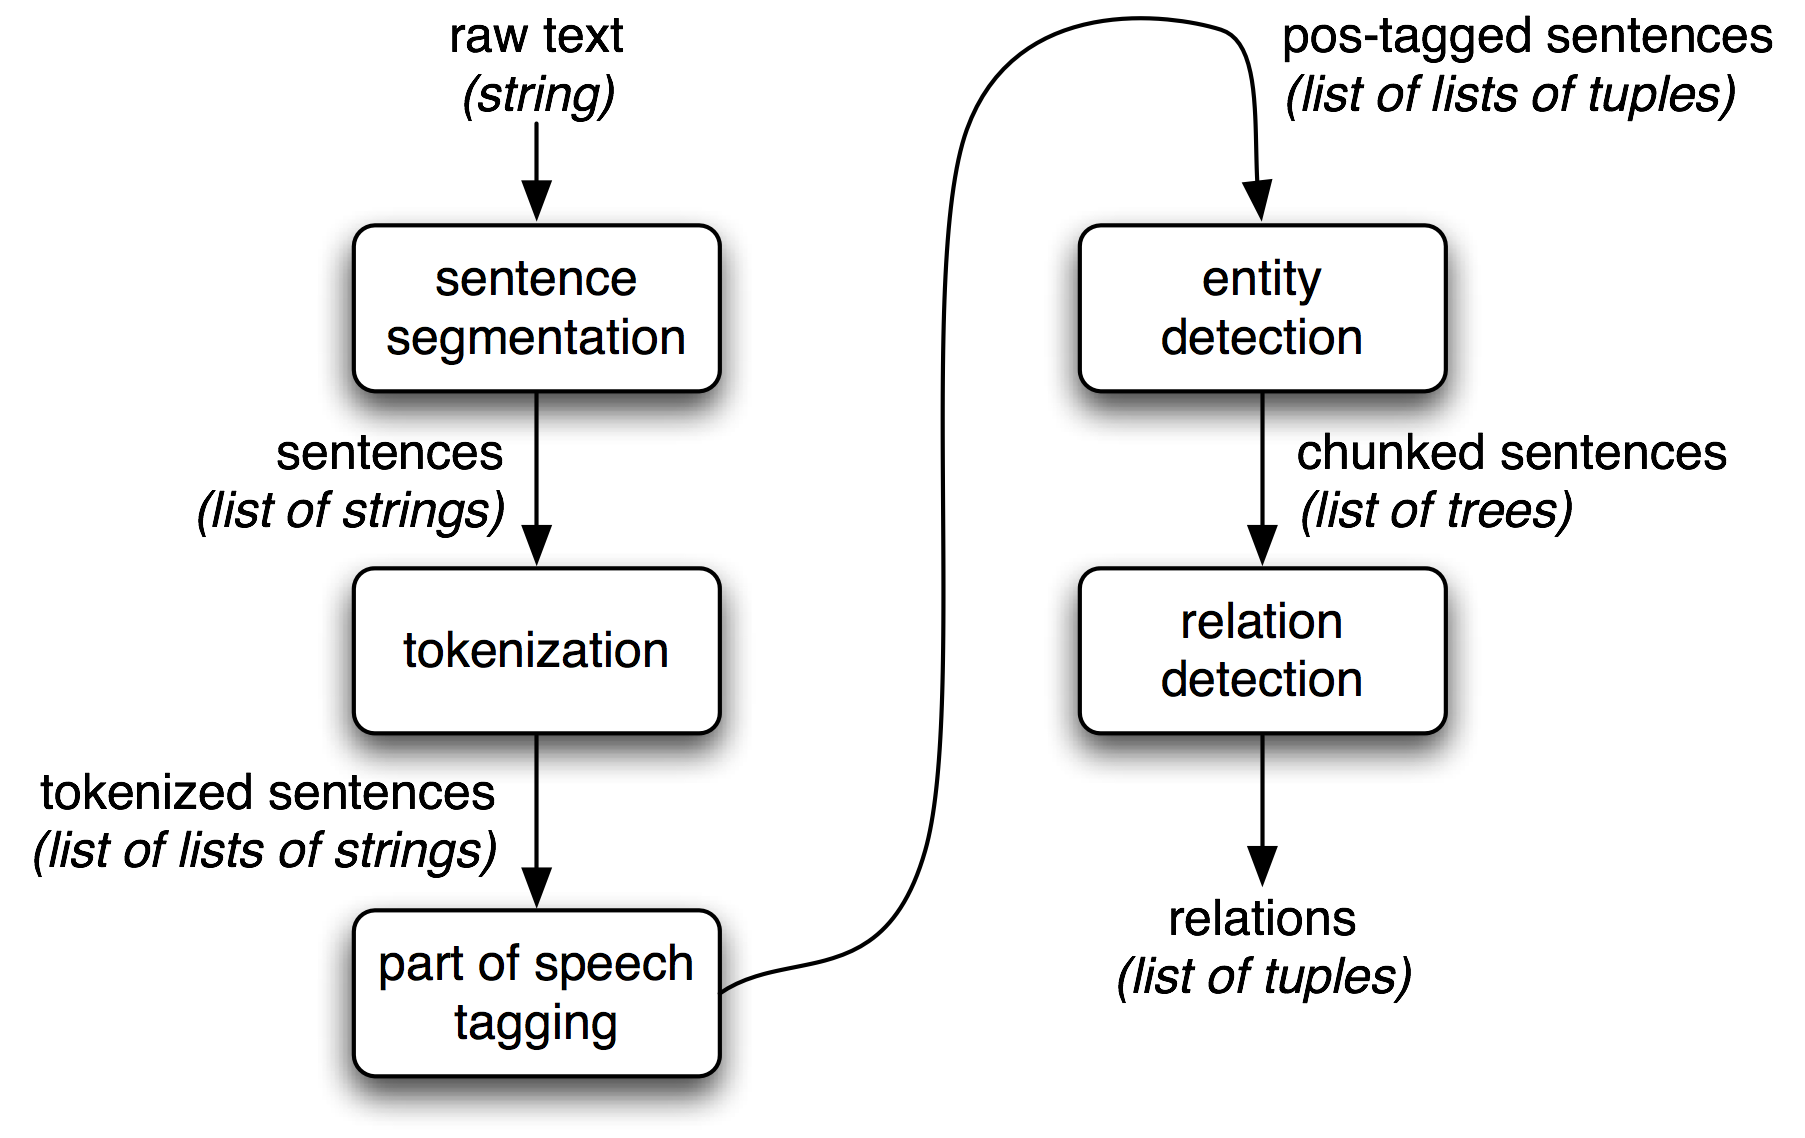
https://www.nltk.org/book/ch07.html

In [31]:
month_data = pd.read_csv("../../Current_Data/data2005to2019.csv", usecols=["Country", "Date", "Cases", "Deaths", 
                                                                       "Summary"])
month_data = month_data.drop(columns=["Cases", "Deaths"])
country_list = ['Benin', 'Burkina Faso', 'Burundi', 'Cameroun', 'Centrafrique', "Ivory Coast", 'Ethiopia', 'Ghana',
               'Guinea', 'Guinea Bissau', 'Gambia', 'Kenya', 'Mali', 'Mauritania', 'Niger', 'Nigeria', 'Dem. Rep. Congo', 
                'Senegal' , 'South Sudan', 'Sudan', 'Sierra Lone', 'Tanzania', 'Chad', 'Togo', 'Uganda']
month_data

,Country,Date,Summary
0,Benin,1/3/05,Note that year 2004 had 53 weeks. Hence the fi...
1,Burkina Faso,1/3/05,Note that year 2004 had 53 weeks. Hence the fi...
2,Ivory Coast,1/3/05,Note that year 2004 had 53 weeks. Hence the fi...
3,Mali,1/3/05,Note that year 2004 had 53 weeks. Hence the fi...
4,Niger,1/3/05,Note that year 2004 had 53 weeks. Hence the fi...
...,...,...,...
5069,Dem. Rep. Congo,12/16/19,"From week 49 to 52 (December 2019), 8 district..."
5070,Sudan,12/16/19,"From week 49 to 52 (December 2019), 8 district..."
5071,Tanzania,12/16/19,"From week 49 to 52 (December 2019), 8 district..."
5072,Chad,12/16/19,"From week 49 to 52 (December 2019), 8 district..."


In [27]:
# nltk.download('averaged_perceptron_tagger')
# nltk.download('tagsets')
txt = month_data.iloc[1]["Summary"]

#doing the first 3 tasks in a simple preprocess function
def preprocess(txt):
    sentences = nltk.sent_tokenize(txt) 
    sentences = [nltk.word_tokenize(sent) for sent in sentences] 
    sentences = [nltk.pos_tag(sent) for sent in sentences]
    #to remove the nested the list/flatten it
    return sentences
    
def country_short_list(sentences):
    countries_present = []
    for sent in sentences:
        c = [country for (country, tag) in sent if tag == "NNP" and (country in country_list or country == "Burkina" \
                                                                     or country == "Côte")]
        
        if c not in countries_present:
            countries_present += c
    return countries_present

print(txt)
print(country_short_list(preprocess(txt)))

Note that year 2004 had 53 weeks. Hence the first week of year 2005 extends from 03 to 09 January. At week 1, 2005, among the 8 countries that reported weekly data to the MDSC, there was no alert or epidemic district.At week 2, 2005, the district of Saponé in Burkina Faso reached the alert threshold. Among the 5 CSF specimens analyzed by Gram, 3 were Gram-positive diplococcus, and 2 specimens were negative. These results evoke S. pneumoniae.No district had reached the alert or epidemic threshold during the 3rd week.District of P, Burkina Faso reached the alert threshold at week 4, with 8 cases (attack rate 5.3 cases/100 000 inhabitants). The 5 cases come from 5 different health centres. The laboratory analysis of CSFs collected showed 3 Gram positive diplococcus; 3 Gram negative diplococcus and 2 negative results.In Burkina Faso the district of Batié is in epidemic phase (AR 15.8). Cases were recruited from two neighbouring health facilities with one bordering Ghana. The results of 9 C